ENVIRON

In [1]:
import os
import sys
from datetime import datetime
sys.path.insert(0, './boruvka/pybuild')

In [2]:
from tqdm import tqdm, trange
from pandarallel import pandarallel
# import swifter
# from swifter import set_defaults
import skimage as ski
import numpy as np
import pandas as pd
from PIL import Image
from skimage import graph

In [3]:
import boruvka_superpixel
from wavelet import utils_wavelet as wv
from skimage.segmentation import slic, felzenszwalb

In [67]:
from skimage import io, color

In [4]:
import networkx as nx

In [5]:
tqdm.pandas()
pandarallel.initialize(progress_bar = True, nb_workers = 8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


DATASET

In [6]:
images = []

In [7]:
for filename in os.listdir(f'./ImageNet_ILSVEC_2010_val'):
    images.append(f'./ImageNet_ILSVEC_2010_val/{filename}')

In [8]:
df = pd.DataFrame(columns = ['filename', 'image', 'label'])

In [9]:
with open('./ILSVRC2010_validation_ground_truth.txt') as f:
    labels = f.readlines()
labels = [int(label.strip()) for label in labels]

In [10]:
print('BEFORE IMPORT:', str(datetime.now()))

BEFORE IMPORT: 2023-11-09 08:54:07.909832


In [14]:
for index, filename in enumerate(tqdm(images[0:1])):
    df.loc[index] = {'filename': filename, 'image': np.array(Image.open(filename).convert('RGB')), 'label': labels[index]}

100%|██████████| 1/1 [00:00<00:00, 66.44it/s]


In [15]:
print('AFTER IMPORT:', str(datetime.now()))

AFTER IMPORT: 2023-11-09 08:54:34.166022


SLIC - about 3 hours per 50k

In [16]:
def slic_conversion(image, num_sp):
    try:
        return slic(image, num_sp)
    except Exception as e:
        print(e)

In [17]:
print('BEFORE SLIC LABEL:', str(datetime.now()))

BEFORE SLIC LABEL: 2023-11-09 08:54:36.309578


In [ ]:
df['slic_label'] = df['image'].parallel_apply(lambda x : slic_conversion(x, 75))

In [19]:
df['slic_label'] = df['image'].progress_apply(lambda x : slic_conversion(x, 75))

100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


In [ ]:
df['slic_label'] = df['image'].swifter.progress_bar(True).apply(lambda x : slic_conversion(x, 75))

In [ ]:
print('AFTER SLIC LABEL:', str(datetime.now()))

In [ ]:
print('BEFORE SLIC GRAPH:', str(datetime.now()))

In [21]:
df['slic_graph'] = df.progress_apply(lambda x : graph.rag_mean_color(x['image'], x['slic_label']), axis = 1)

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


In [22]:
print('AFTER SLIC GRAPH:', str(datetime.now()))

AFTER SLIC GRAPH: 2023-11-09 08:55:12.956478


In [64]:
image = np.zeros(df['image'][0].shape)

In [69]:
df['image'][0] = color.rgb2lab(df['image'][0])

/tmp/ipykernel_341997/2980237466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'][0] = color.rgb2lab(df['image'][0])


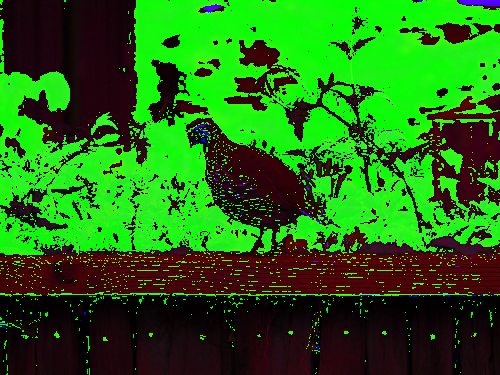

In [71]:
Image.fromarray(df['image'][0].astype(np.uint8))

In [75]:
df['image'][0].max()

100.0

In [77]:
label = slic(df['image'][0], 75)

In [78]:
G = graph.rag_mean_color(df['image'][0], label)

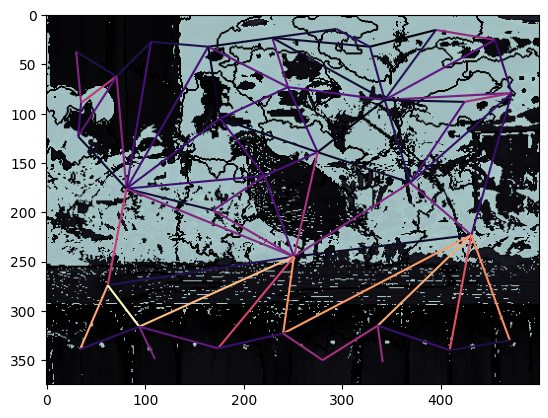

In [80]:
ski.graph.show_rag(label, G, df['image'][0].astype(np.uint8))

BORUVKA SUPERPIXEL HIERARCHY - about 1 hour per 50k

In [51]:
def boruvka_conversion(image, num_sp):
    try:
        image_edge = np.zeros((image.shape[:2]), dtype = image.dtype)

        bsp = boruvka_superpixel.BoruvkaSuperpixel()
        bsp.build_2d(image, image_edge)
        bsp_label = bsp.label(num_sp)

        return bsp_label
    except Exception as e:
        print(e)

In [52]:
print('BEFORE BORUVKA LABEL:', str(datetime.now()))

BEFORE BORUVKA LABEL: 2023-11-09 09:04:47.637831


In [53]:
df['boruvka_label'] = df['image'].parallel_apply(lambda x : boruvka_conversion(x, 75))

In [ ]:
print('BEFORE BORUVKA LABEL:', str(datetime.now()))

In [ ]:
print('BEFORE BORUVKA GRAPH:', str(datetime.now()))

In [55]:
G = graph.rag_mean_color(df['image'][0], df['boruvka_label'][0])

In [ ]:
bsp.average()

In [56]:
image = df['image'][0]
image_edge = np.zeros((image.shape[:2]), dtype = image.dtype)

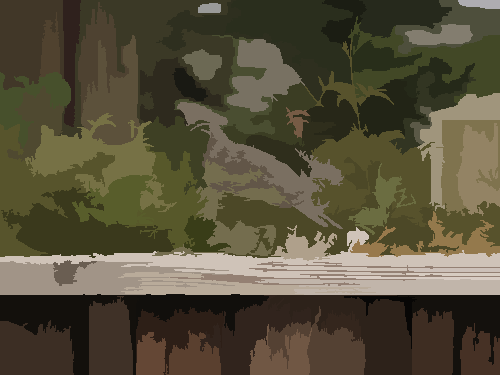

In [62]:
bsp = boruvka_superpixel.BoruvkaSuperpixel()
bsp.build_2d(image, image_edge)
Image.fromarray(bsp.average(75, 3, image))

In [54]:
df['boruvka_graph'] = df.parallel_apply(lambda x : graph.rag_mean_color(df['image'], df['boruvka_label']), axis = 1)

RuntimeError: array type not supported

In [ ]:
print('AFTER BORUVKA GRAPH:', str(datetime.now()))

SAVE FOR TEMP

In [ ]:
df.to_csv('./imagenet50k.csv')